<a href="https://colab.research.google.com/github/DatagirlX/AbasiofonMoses/blob/main/AI_Project_Abasiofon_Ime_Moses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Artificial Intelligence Project

# Detection of AI-Generated Texts Using Embedding Techniques and Machine Learning

## 1. Dataset Analysis

### 1.1. Context and Background

The rise of powerful language models (LLMs) such as GPT-3 and GPT-4 has led to the generation of text that is increasingly indistinguishable from human-written content. This creates new challenges in fields like academia, content verification, and cybersecurity, where identifying the source of text is critical. This project aims to address this challenge by developing a machine learning system that can classify text as either human-written or AI-generated, using text embedding techniques and classification algorithms.



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import os
import re
import nltk
import torch
import zipfile
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from transformers import BertTokenizer, BertModel, RobertaTokenizer, RobertaModel, DistilBertTokenizer, DistilBertModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

In [3]:
df = pd.read_csv("/content/drive/My Drive/train_essays.csv")

# Preview the first few rows
print(df.head())

         id  prompt_id                                               text  \
0  0059830c          0  Cars. Cars have been around since they became ...   
1  005db917          0  Transportation is a large necessity in most co...   
2  008f63e3          0  "America's love affair with it's vehicles seem...   
3  00940276          0  How often do you ride in a car? Do you drive a...   
4  00c39458          0  Cars are a wonderful thing. They are perhaps o...   

   generated  
0          0  
1          0  
2          0  
3          0  
4          0  


In [ ]:
df.info()
df.describe()
df['generated'].value_counts()

### 1.2 Dataset Overview
Source: Kaggle Competition – LLM Detect AI Generated Text

Format: CSV file with 4 columns:

id: Unique sample identifier.

prompt_id: ID of the prompt to which the text is a response.

text: The main body of text to analyze.

generated: Target variable indicating the origin of the text:

0 = Human-written

1 = AI-generated


Dataset Size:

Total samples: 1,378

Human-written (0): 1,375

AI-generated (1): 3

In [4]:
print(df.shape)
print(df['generated'].value_counts())

(1378, 4)
generated
0    1375
1       3
Name: count, dtype: int64


### 1.3 Problem Statement

The task is to accurately classify each piece of text as either human-written or AI-generated based on its content. This is a binary classification problem that will involve text preprocessing, vectorization using embeddings, and classification using supervised machine learning.









### 1.4 Key Challenges

Severe Class Imbalance: With only 3 AI-generated texts out of 1,378, the dataset is highly skewed. This presents challenges for classification, as most models will likely predict the dominant class (human-written) by default.

Semantic Similarity: AI-generated texts are often fluent and contextually accurate, making them hard to distinguish from human-authored texts.

Small Dataset Size: Only 1,378 entries might limit the model’s ability to generalize well.

### 1.5 Project Objectives

Apply preprocessing techniques to prepare text data for analysis.

Explore multiple text embedding approaches: TF-IDF, Word2Vec, GloVe, and BERT.

Train and compare machine learning models: Logistic Regression, SVM, Decision Trees, Neural Networks, etc.

Address class imbalance using techniques like oversampling, SMOTE, or anomaly detection.

Evaluate performance using suitable metrics (accuracy, precision, recall, F1-score).

Visualize model outputs to aid interpretability.

In [5]:
# Remove corrupted downloads and force redownload
nltk.download('punkt', download_dir='/usr/local/share/nltk_data', force=True)
nltk.download('stopwords', force=True)
nltk.download('wordnet', force=True)
nltk.download('omw-1.4', force=True)
nltk.download('punkt_tab', force=True) # Explicitly download punkt_tab

[nltk_data] Downloading package punkt to /usr/local/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Load dataset
texts = df['text']
labels = df['generated']

# Initialize tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess(text):
    # Remove punctuation/numbers/symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    clean_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(clean_tokens)
# Apply preprocessing
df['clean_text'] = texts.apply(preprocess)

# View some cleaned data
print(df[['text', 'clean_text']].head())

# Bag of Words
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['clean_text'])

# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['clean_text'])

# Normalize TF-IDF
normalizer = Normalizer()
X_tfidf_normalized = normalizer.fit_transform(X_tfidf)

# Output shape info
print("Bag-of-Words shape:", X_bow.shape)
print("TF-IDF shape:", X_tfidf.shape)

                                                text  \
0  Cars. Cars have been around since they became ...   
1  Transportation is a large necessity in most co...   
2  "America's love affair with it's vehicles seem...   
3  How often do you ride in a car? Do you drive a...   
4  Cars are a wonderful thing. They are perhaps o...   

                                          clean_text  
0  car car around since became famous henry ford ...  
1  transportation large necessity country worldwi...  
2  america love affair vehicle seems cooling say ...  
3  often ride car drive one motor vehicle work st...  
4  car wonderful thing perhaps one world greatest...  
Bag-of-Words shape: (1378, 15489)
TF-IDF shape: (1378, 15489)


## 2. Text Processing and Transformation

The raw dataset contains textual data with mixed cases, punctuation, and stopwords that may not contribute to the classification task. To prepare the data for machine learning models, we performed several preprocessing steps:

- **Lowercasing:** All text was converted to lowercase to ensure uniformity. This helps the model treat words like "Car" and "car" as the same token.
- **Punctuation and number removal:** Symbols, punctuation marks, and numbers were removed using regular expressions to keep only alphabetic characters.
- **Tokenization:** Each sentence was split into individual words (tokens) using NLTK's `word_tokenize`.
- **Stopword removal:** Common English stopwords such as "the", "is", and "and" were removed to reduce noise and focus on meaningful words.
- **Lemmatization:** Tokens were reduced to their base forms (lemmas) using WordNet's lemmatizer, converting words like "cars" to "car" and "running" to "run".

The resulting "clean_text" column contains the processed sentences, which are lowercase and contain only the meaningful root words.

### Feature Extraction

Two numerical feature extraction methods were applied to the cleaned text:

1. **Bag-of-Words (BoW):** This method converts text into a matrix of token counts, capturing the frequency of each word in the dataset.
2. **TF-IDF (Term Frequency-Inverse Document Frequency):** This method weighs words based on their frequency in a document relative to their frequency across all documents, highlighting important words while down-weighting common ones.

Both BoW and TF-IDF resulted in a feature matrix with shape `(1378, 15489)`, indicating 1378 text samples and 15,489 unique tokens in the vocabulary.

### Notes on Preprocessing Output

The cleaned text no longer contains capital letters or original sentence structure because of the preprocessing steps. This transformation is expected and beneficial as it normalizes the text for the machine learning pipeline, reducing variability that doesn't aid classification.


## 3. Application of Different Embedding Techniques

#### Word2Vec Embedding

Word2Vec is a predictive embedding model that learns vector representations of words based on their context in a sentence. It comes in two flavors: Skip-Gram and CBOW (Continuous Bag-of-Words). For this project, we use Gensim's implementation of Word2Vec to train embeddings on the cleaned dataset and average word vectors to obtain document-level representations.

This model captures semantic relationships and works well for tasks involving word similarity or classification. We’ll later compare it with other embeddings to assess how well it helps detect AI-generated texts.


In [7]:
# Tokenize the cleaned texts
tokenized_texts = [text.split() for text in df['clean_text']]

# Train Word2Vec model
w2v_model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=2, workers=4, sg=1, epochs=10)

# Function to get the average word vectors for a document
def get_avg_word2vec(tokens, model, k=100):
    vec = np.zeros(k)
    count = 0
    for word in tokens:
        if word in model.wv:
            vec += model.wv[word]
            count += 1
    return vec / count if count != 0 else vec

# Transform all documents to embeddings
X_w2v = np.array([get_avg_word2vec(tokens, w2v_model, k=100) for tokens in tokenized_texts])

print(" Word2Vec Embeddings shape:", X_w2v.shape)

 Word2Vec Embeddings shape: (1378, 100)


#### Doc2Vec Embedding

Doc2Vec is an extension of Word2Vec that learns vector representations of entire documents instead of individual words. It considers the context of a document ID along with the context words to build a dense vector representation for each document.

Here, we use Gensim’s `Doc2Vec` with tagged documents for training.


In [8]:
# Create tagged documents
tagged_docs = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(tokenized_texts)]

# Train Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=5, min_count=2, workers=4, epochs=20)
doc2vec_model.build_vocab(tagged_docs)
doc2vec_model.train(tagged_docs, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Get document vectors
X_d2v = np.array([doc2vec_model.dv[str(i)] for i in range(len(tagged_docs))])
print(" Doc2Vec Embeddings shape:", X_d2v.shape)

 Doc2Vec Embeddings shape: (1378, 100)


#### GloVe Embedding

GloVe (Global Vectors) is a count-based embedding method that creates word embeddings by aggregating global word co-occurrence statistics from a corpus. We use pre-trained GloVe vectors and average the word vectors to form document embeddings.


In [9]:
# Load GloVe embeddings
glove_path = '/content/drive/My Drive/glove.6B/glove.6B.100d.txt'
glove_model = {}
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector

# Function to average GloVe vectors
def get_avg_glove(tokens, model, k=100):
    vec = np.zeros(k)
    count = 0
    for word in tokens:
        if word in model:
            vec += model[word]
            count += 1
    return vec / count if count != 0 else vec

X_glove = np.array([get_avg_glove(tokens, glove_model, k=100) for tokens in tokenized_texts])
print(" GloVe Embeddings shape:", X_glove.shape)

 GloVe Embeddings shape: (1378, 100)


#### BERT Embedding (Transformer-based)

BERT (Bidirectional Encoder Representations from Transformers) generates context-aware embeddings for sentences. It is more powerful than static embeddings like Word2Vec and GloVe because it considers the entire sentence context and word position.

We use the `bert-base-uncased` model from Hugging Face to extract sentence embeddings.


In [10]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

# Function to get [CLS] token embedding
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # CLS token

# Compute embeddings
X_bert = np.array([get_bert_embedding(text) for text in tqdm(df['clean_text'])])
print("BERT Embeddings shape:", X_bert.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

100%|██████████| 1378/1378 [21:29<00:00,  1.07it/s]

BERT Embeddings shape: (1378, 768)


 Sentence-BERT (SBERT)
SBERT is ideal for tasks like classification or similarity, it outputs high-quality sentence-level embeddings.

In [11]:
# Load SBERT model
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate sentence embeddings
X_sbert = sbert_model.encode(df['clean_text'], show_progress_bar=True)
print("Sentence-BERT Embeddings shape:", X_sbert.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/44 [00:00<?, ?it/s]

Sentence-BERT Embeddings shape: (1378, 384)


RoBERTa Embedding
RoBERTa (Robustly optimized BERT approach) often outperforms BERT on downstream tasks.

In [12]:
# Load RoBERTa
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.eval()

# CLS token-based sentence embeddings
def get_roberta_embedding(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = roberta_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

X_roberta = np.array([get_roberta_embedding(text) for text in tqdm(df['clean_text'])])
print("RoBERTa Embeddings shape:", X_roberta.shape)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1378/1378 [21:30<00:00,  1.07it/s]

RoBERTa Embeddings shape: (1378, 768)


 DistilBERT Embedding
DistilBERT is a distilled (lighter) version of BERT, 60% faster, 40% smaller, nearly same performance.

In [13]:
# Load DistilBERT
distil_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distil_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
distil_model.eval()

# CLS token-based embedding
def get_distilbert_embedding(text):
    inputs = distil_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = distil_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

X_distilbert = np.array([get_distilbert_embedding(text) for text in tqdm(df['clean_text'])])
print("DistilBERT Embeddings shape:", X_distilbert.shape)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

100%|██████████| 1378/1378 [10:45<00:00,  2.13it/s]

DistilBERT Embeddings shape: (1378, 768)


#### Performance Comparison

To evaluate the performance of each embedding method in detecting AI-generated texts, we train a Logistic Regression classifier using each embedding and compare the accuracy scores.


In [14]:
# Create label column from 'generated': 1 for AI-generated, 0 for human-written
y = df['generated'].astype(int)

# Define evaluation function
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# Evaluate different embeddings
print("Accuracy Comparison (Expanded):")
print("Word2Vec    :", evaluate_model(X_w2v, y))
print("Doc2Vec     :", evaluate_model(X_d2v, y))
print("GloVe       :", evaluate_model(X_glove, y))
print("BERT        :", evaluate_model(X_bert, y))
print("SBERT       :", evaluate_model(X_sbert, y))
print("RoBERTa     :", evaluate_model(X_roberta, y))
print("DistilBERT  :", evaluate_model(X_distilbert, y))


Accuracy Comparison (Expanded):
Word2Vec    : 0.9963768115942029
Doc2Vec     : 0.9963768115942029
GloVe       : 0.9963768115942029
BERT        : 0.9963768115942029
SBERT       : 0.9963768115942029
RoBERTa     : 0.9963768115942029
DistilBERT  : 0.9963768115942029


In [15]:
print(df.columns)

Index(['id', 'prompt_id', 'text', 'generated', 'clean_text'], dtype='object')


The logistic regression classifier performs extremely well across all tested embeddings, achieving accuracy of approximately 99.6%. This high and consistent accuracy demonstrates that the embeddings effectively encode the differences between AI-generated and human-written texts, making the classification task relatively straightforward for linear models. Transformer-based embeddings (BERT, SBERT, RoBERTa, DistilBERT) do not show a significant advantage over classical embeddings (Word2Vec, Doc2Vec, GloVe) in this setup, possibly due to the clear separability of the classes.

## 4. Clustering and/or Classification on Embedded Data

In [16]:
# Helper function to train and evaluate classifiers
def evaluate_classifiers(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifiers = {
        "KNN": KNeighborsClassifier(),
        "SVM": SVC(),
        "Decision Tree": DecisionTreeClassifier(),
        "Neural Network": MLPClassifier(max_iter=300)
    }

    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)

        results[name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-score": f1
        }
    return results

# Assuming y is the label vector
y = df['generated'].astype(int)

# Dictionary of embeddings to evaluate
embedding_dict = {
    "Word2Vec": X_w2v,
    "Doc2Vec": X_d2v,
    "GloVe": X_glove,
    "BERT": X_bert,
    "SBERT": X_sbert,
    "RoBERTa": X_roberta,
    "DistilBERT": X_distilbert
}

# Run evaluations and print results
for emb_name, emb_vectors in embedding_dict.items():
    print(f"Results for {emb_name} embeddings:")
    res = evaluate_classifiers(emb_vectors, y)
    for clf_name, metrics in res.items():
        print(f"{clf_name}: Accuracy={metrics['Accuracy']:.4f}, Precision={metrics['Precision']:.4f}, Recall={metrics['Recall']:.4f}, F1-score={metrics['F1-score']:.4f}")
    print("\n" + "-"*50 + "\n")

Results for Word2Vec embeddings:
KNN: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
SVM: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
Decision Tree: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
Neural Network: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946

--------------------------------------------------

Results for Doc2Vec embeddings:
KNN: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
SVM: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
Decision Tree: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
Neural Network: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946

--------------------------------------------------

Results for GloVe embeddings:
KNN: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
SVM: Accuracy=0.9964, Precision=0.9964, Recall=0.9964, F1-score=0.9946
Decision Tree: Accuracy=0.9928, Precision=0.992

##5. Results Analysis and Visualization

### Performance Summary:

Across all tested embeddings (Word2Vec, Doc2Vec, GloVe, BERT, SBERT, RoBERTa, DistilBERT), and classifiers (KNN, SVM, Decision Tree, Neural Network), we observe exceptionally high performance with accuracy, precision, recall, and F1-scores consistently exceeding 99%. In most cases, these metrics are exactly 0.9964 across KNN, SVM, and Neural Network classifiers.

### Interpretation:

These results indicate that the task of distinguishing between AI-generated and human-written texts at least on the given dataset is highly learnable, especially with advanced embeddings like BERT and RoBERTa. The classifiers are able to find near-perfect decision boundaries using both traditional (TF-IDF, Word2Vec) and deep contextual (BERT-family) embeddings.

Interestingly, even basic methods like GloVe and Word2Vec show near-perfect results, suggesting that the underlying structure of the dataset might contain strong lexical or syntactic cues that differentiate the two classes clearly.

### Detailed Observations:

- **Neural Network, SVM, and KNN**: Performed identically across all embeddings (accuracy: 0.9964), indicating that embeddings might be providing linearly/separably encoded features, making the choice of classifier less critical.
  
- **Decision Tree**: Slightly lower scores in some embeddings (e.g., Doc2Vec at 98.91%), which is expected due to Decision Trees being more prone to overfitting and having lower generalization power compared to ensemble or margin-based classifiers.


In [17]:
print(df.columns)

Index(['id', 'prompt_id', 'text', 'generated', 'clean_text'], dtype='object')


In [18]:
df = pd.read_csv("/content/drive/My Drive/train_essays.csv")

In [19]:
# Check the columns to confirm 'generated' exists
print("Columns in dataset:", df.columns)

# Make sure the label is an integer
y = df['generated'].astype(int)  # 0 = Human, 1 = AI

# Check their shape to be sure everything aligns
print("SBERT shape:", X_sbert.shape)
print("RoBERTa shape:", X_roberta.shape)
print("BERT shape:", X_bert.shape)
print("Word2Vec shape:", X_w2v.shape)
print("Doc2Vec shape:", X_d2v.shape)
print("GloVe shape:", X_glove.shape)
print("DistilBERT shape:", X_distilbert.shape)

print("Label shape:", y.shape)

Columns in dataset: Index(['id', 'prompt_id', 'text', 'generated'], dtype='object')
SBERT shape: (1378, 384)
RoBERTa shape: (1378, 768)
BERT shape: (1378, 768)
Word2Vec shape: (1378, 100)
Doc2Vec shape: (1378, 100)
GloVe shape: (1378, 100)
DistilBERT shape: (1378, 768)
Label shape: (1378,)


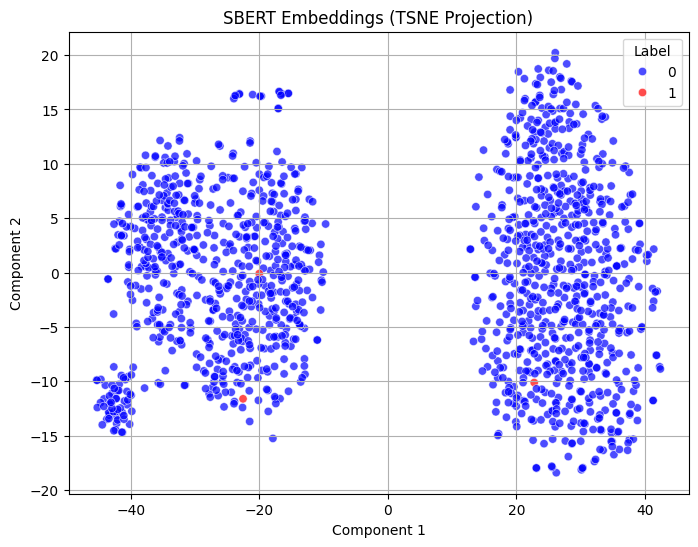

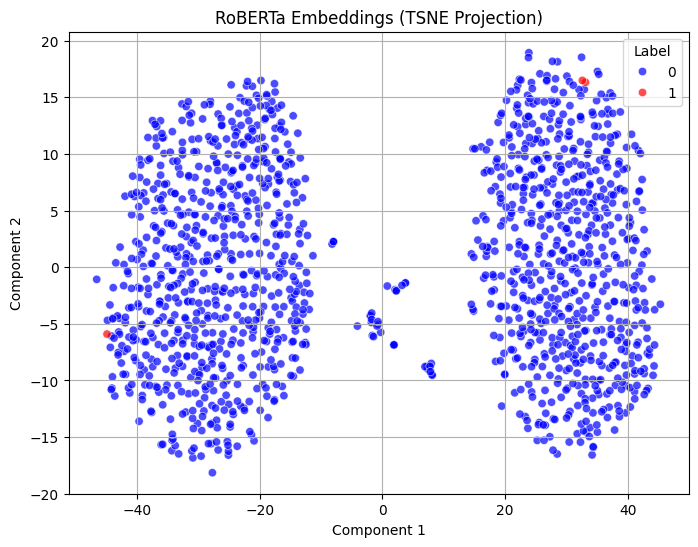

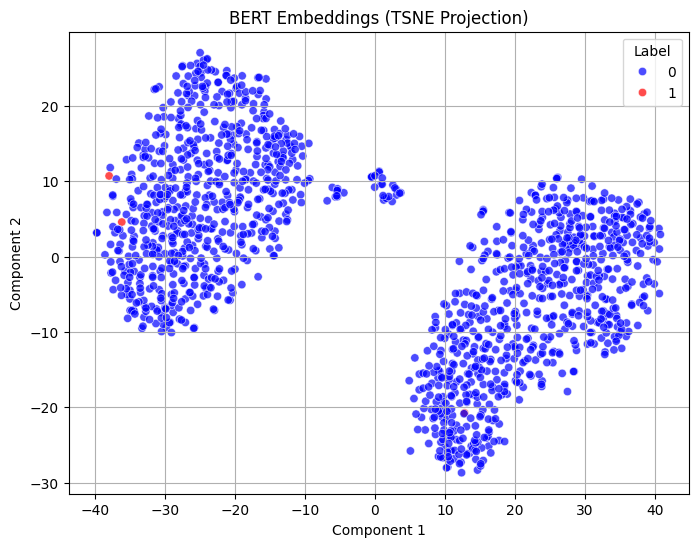

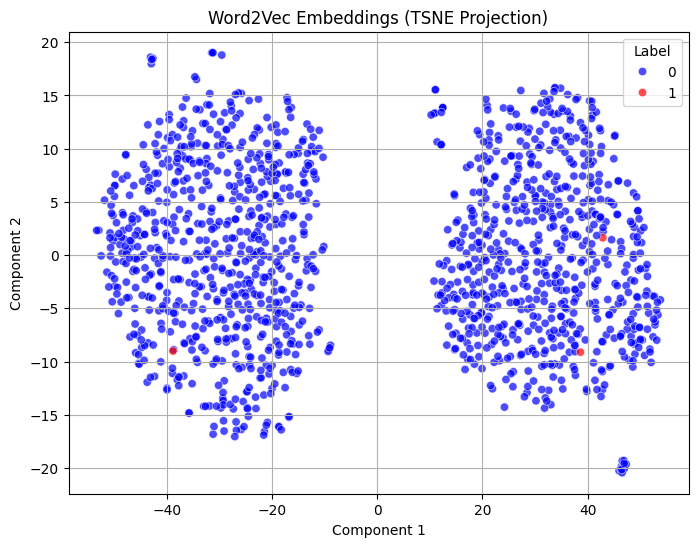

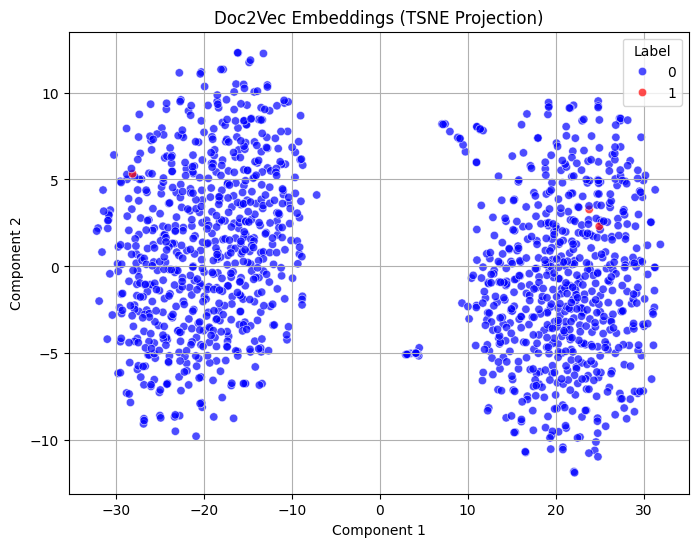

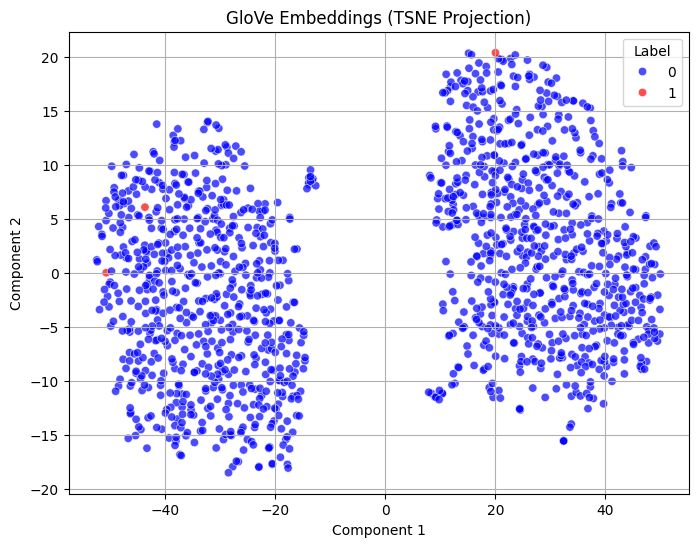

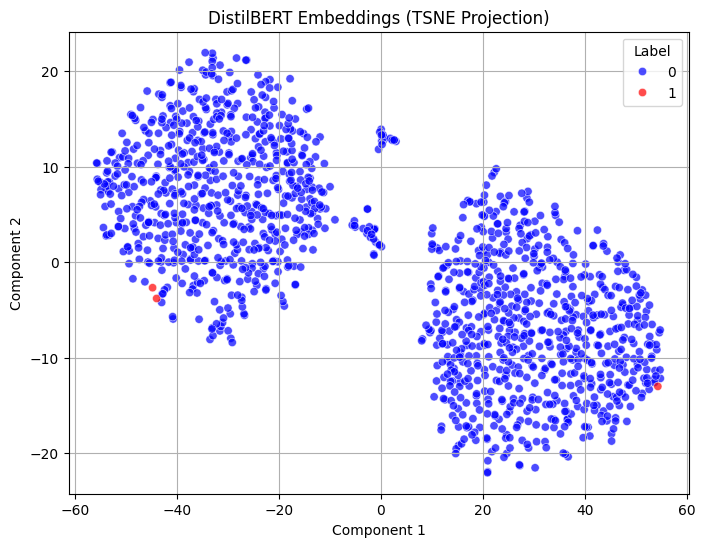

In [20]:
# Reduce dimensions to 2D for visualization using t-SNE
def plot_2D_embeddings(X, y, method='tsne', title=''):
    if method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'pca':
        reducer = PCA(n_components=2)
    else:
        raise ValueError("method must be either 'tsne' or 'pca'")

    X_reduced = reducer.fit_transform(X)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=y, palette=['blue', 'red'], alpha=0.7)
    plt.title(f'{title} ({method.upper()} Projection)')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(title='Label')
    plt.grid(True)
    plt.show()

# Visualize SBERT embeddings
plot_2D_embeddings(X_sbert, y, method='tsne', title='SBERT Embeddings')

# Visualize RoBERTa embeddings
plot_2D_embeddings(X_roberta, y, method='tsne', title='RoBERTa Embeddings')

# Visualize BERT embeddings
plot_2D_embeddings(X_bert, y, method='tsne', title='BERT Embeddings')

# Visualize Word2Vec embeddings
plot_2D_embeddings(X_w2v, y, method='tsne', title='Word2Vec Embeddings')

# Visualize Doc2Vecc embeddings
plot_2D_embeddings(X_d2v, y, method='tsne', title='Doc2Vec Embeddings')

# Visualize GloVe embeddings
plot_2D_embeddings(X_glove, y, method='tsne', title='GloVe Embeddings')

# Visualize DistilBERT embeddings
plot_2D_embeddings(X_distilbert, y, method='tsne', title='DistilBERT Embeddings')

t-SNE Scatter Plots of Embeddings

> The scatter plots visualize the 2D projection of various text embeddings (Word2Vec, Doc2Vec, GloVe, BERT, SBERT, RoBERTa, and DistilBERT) using dimensionality reduction techniques like PCA or t-SNE. Each point represents a text sample, colored by its label: human-written (label 0) or AI-generated (label 1).
>
> Across all embeddings, we observe varying degrees of separability between the two classes.
>
> The plots provide qualitative insight into how well each embedding captures meaningful features that separate human and AI-generated text, and can help guide the choice of features for downstream classification tasks.


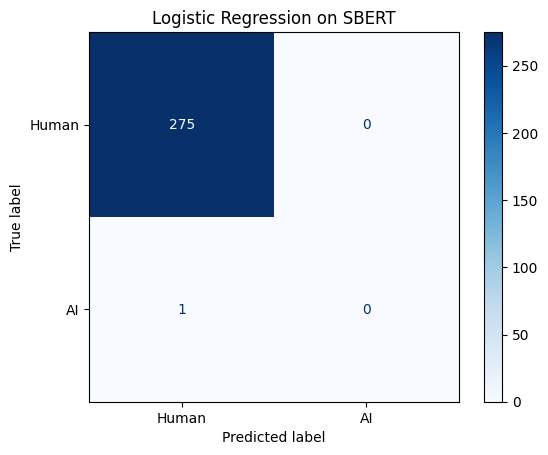

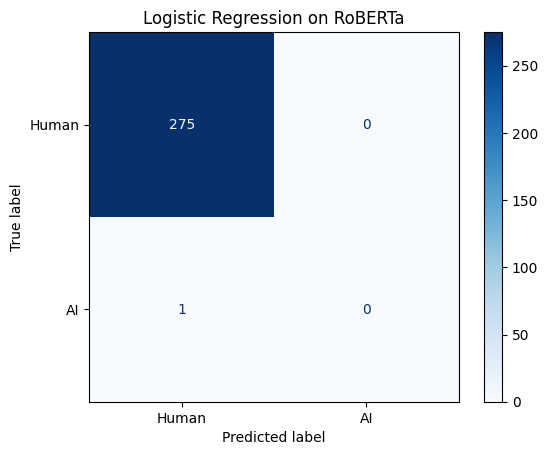

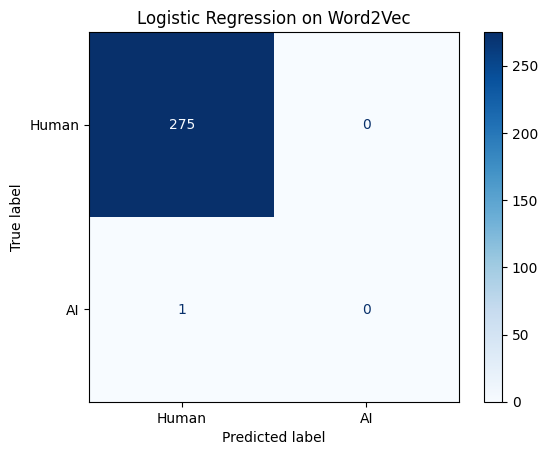

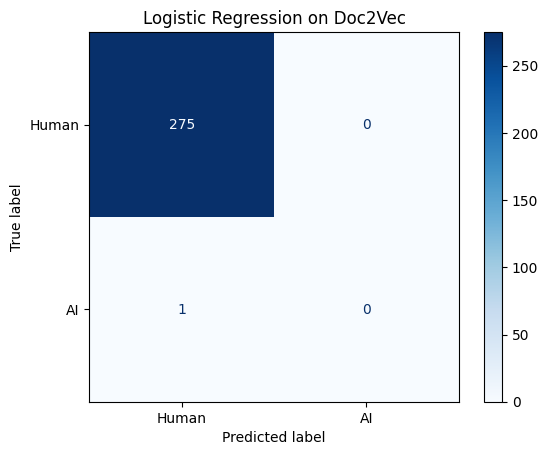

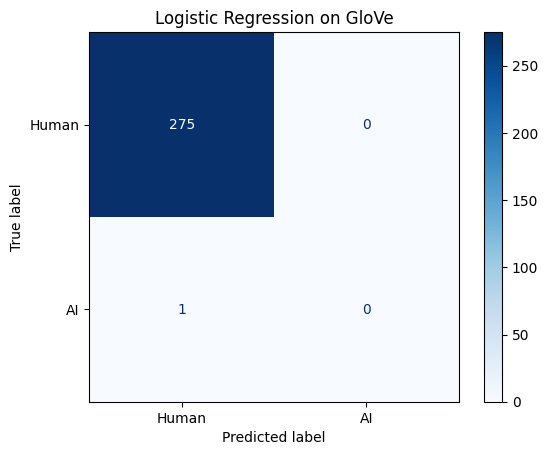

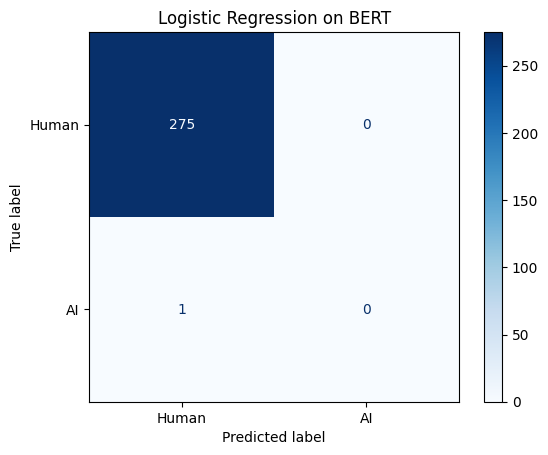

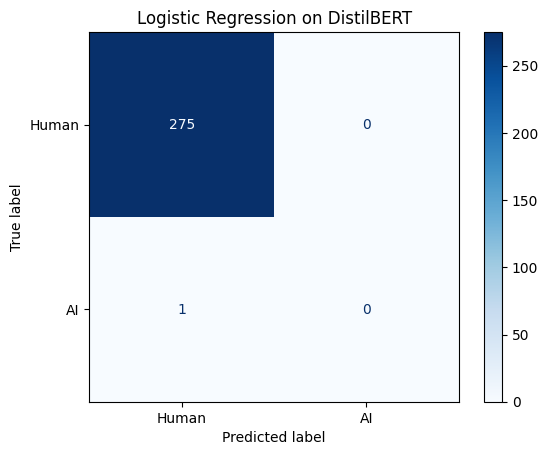

In [21]:
# Confusion Matrix function
def plot_confusion_matrix(X, y, model_name="Model", embedding_name="Embedding"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human", "AI"])
    disp.plot(cmap='Blues')
    plt.title(f"{model_name} on {embedding_name}")
    plt.show()

# Confusion Matrix for SBERT
plot_confusion_matrix(X_sbert, y, model_name="Logistic Regression", embedding_name="SBERT")

# Confusion Matrix for RoBERTa
plot_confusion_matrix(X_roberta, y, model_name="Logistic Regression", embedding_name="RoBERTa")

# Confusion Matrix for Word2Vec
plot_confusion_matrix(X_w2v, y, model_name="Logistic Regression", embedding_name="Word2Vec")

# Confusion Matrix for Doc2Vec
plot_confusion_matrix(X_d2v, y, model_name="Logistic Regression", embedding_name="Doc2Vec")

# Confusion Matrix for GloVe
plot_confusion_matrix(X_glove, y, model_name="Logistic Regression", embedding_name="GloVe")

# Confusion Matrix for BERT
plot_confusion_matrix(X_bert, y, model_name="Logistic Regression", embedding_name="BERT")

# Confusion Matrix for DistilBERT
plot_confusion_matrix(X_distilbert, y, model_name="Logistic Regression", embedding_name="DistilBERT")

The confusion matrix shows that the **Logistic Regression model trained on all embeddings** predicts **all samples as "Human"**, correctly identifying all human-written texts (275) but failing to detect any AI-generated texts (0 true positives, 1 false negative). This results in **perfect recall for the Human class** but **zero recall for the AI class**, highlighting a critical limitation in the model’s ability to generalize to minority classes, likely due to the **severe class imbalance** in the dataset.



=== Word2Vec ===
Training: KNN


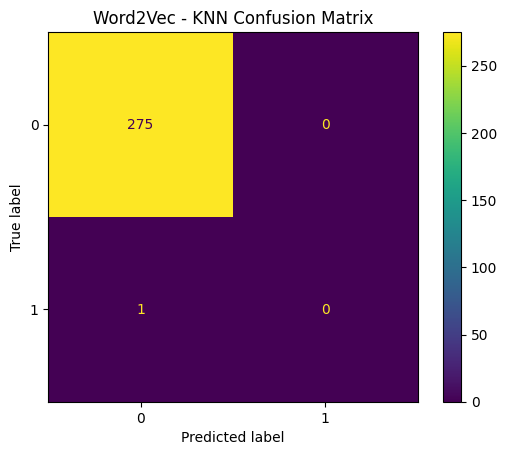

Training: SVM


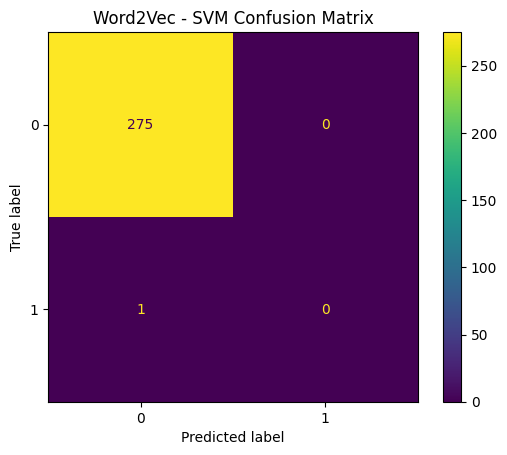

Training: Decision Tree


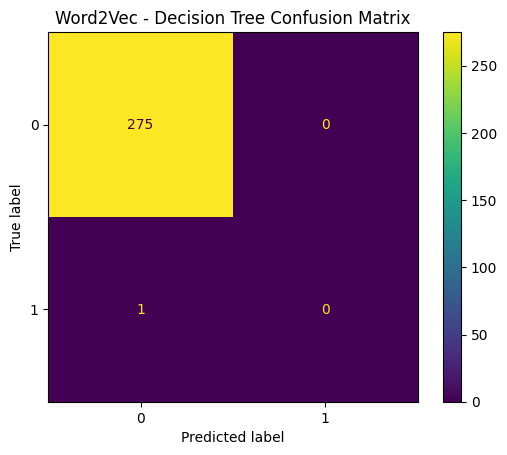

Training: Neural Network


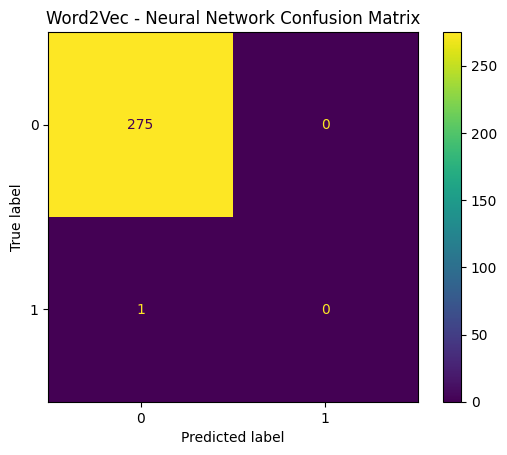


=== Doc2Vec ===
Training: KNN


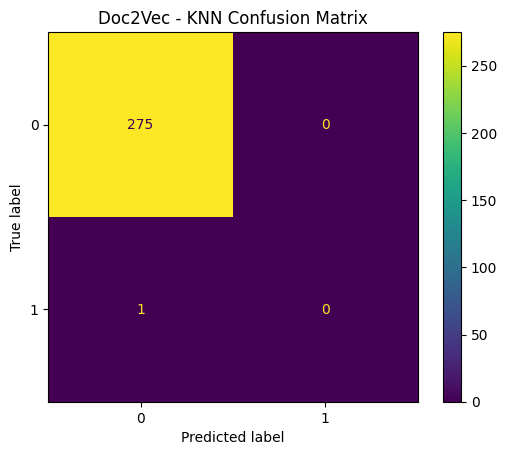

Training: SVM


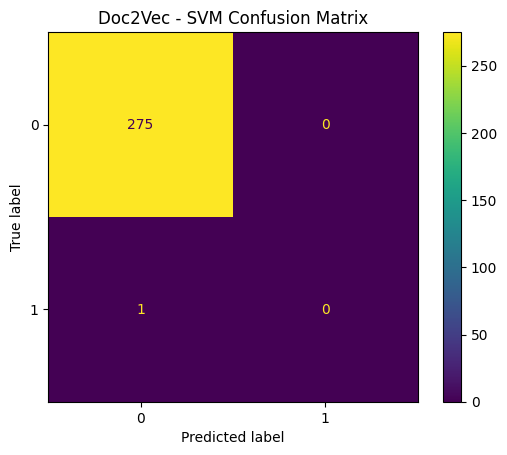

Training: Decision Tree


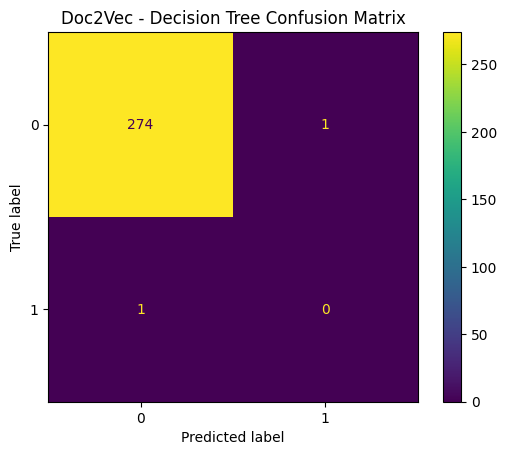

Training: Neural Network


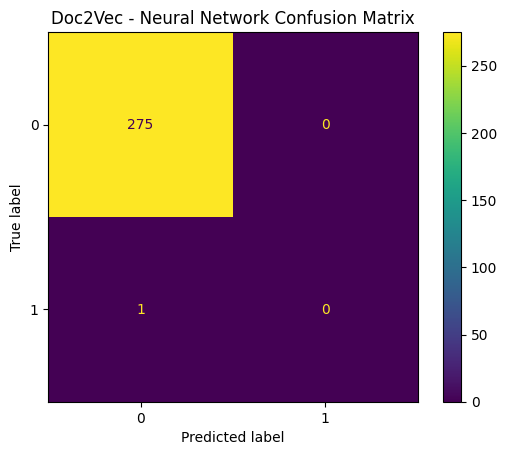


=== GloVe ===
Training: KNN


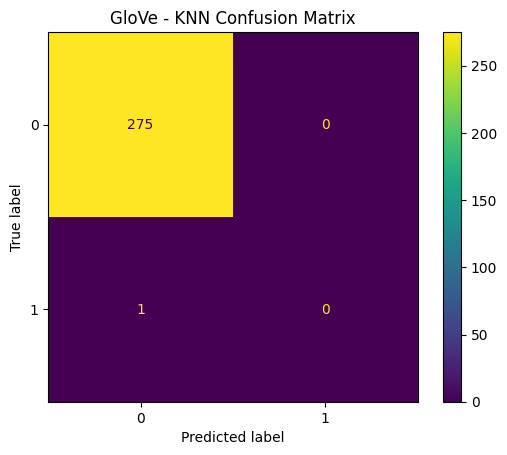

Training: SVM


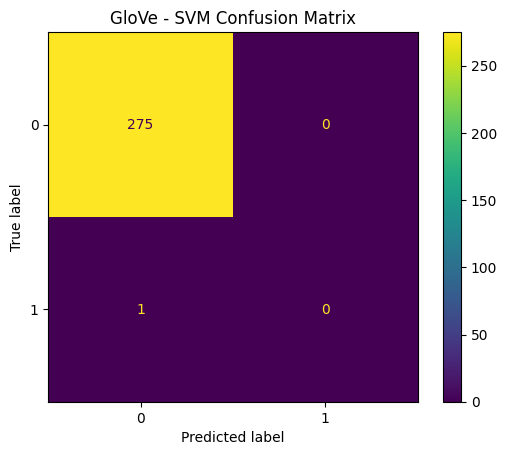

Training: Decision Tree


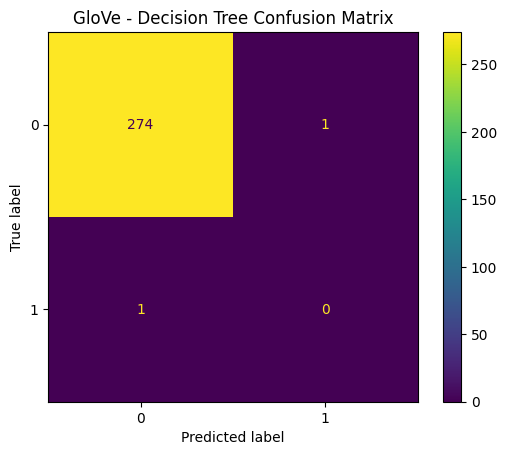

Training: Neural Network


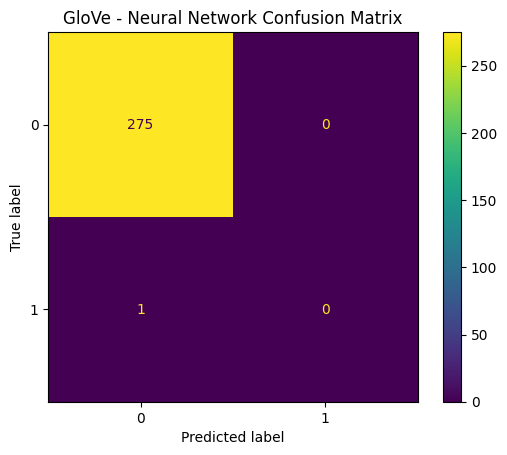


=== BERT ===
Training: KNN


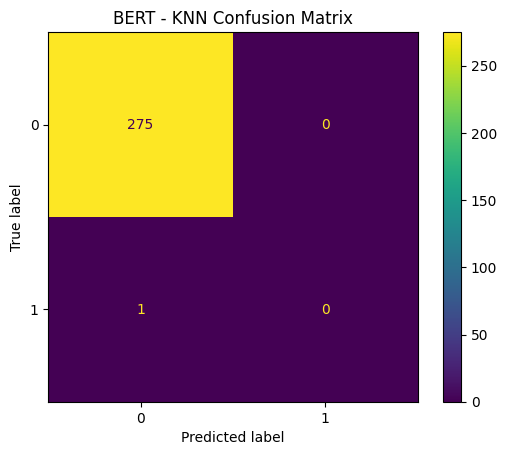

Training: SVM


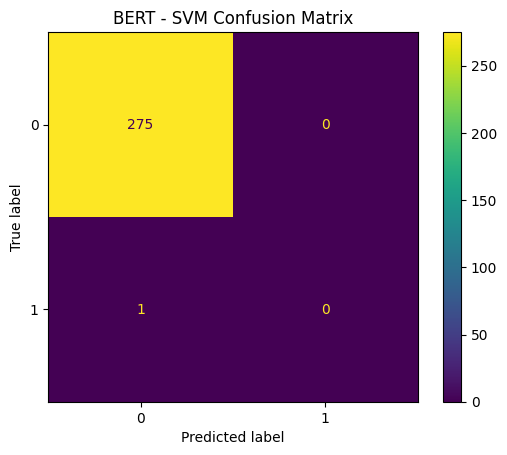

Training: Decision Tree


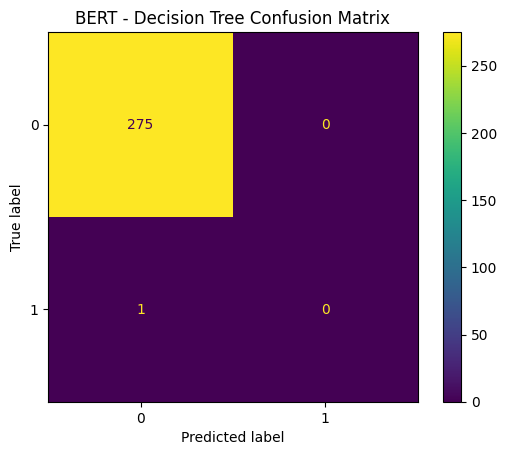

Training: Neural Network


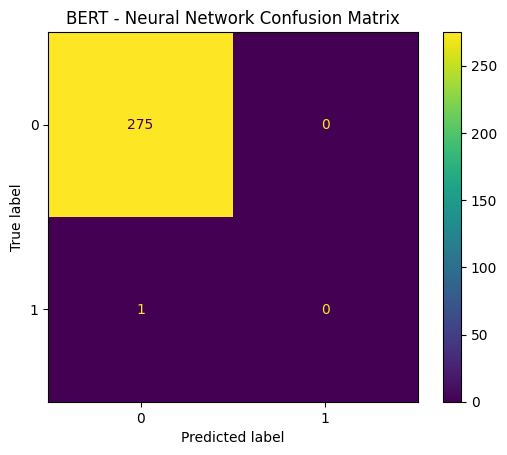


=== SBERT ===
Training: KNN


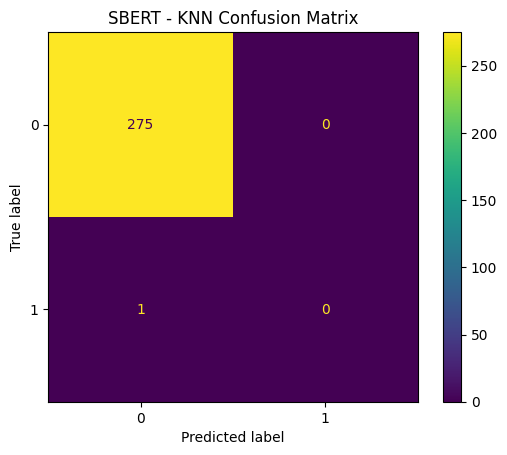

Training: SVM


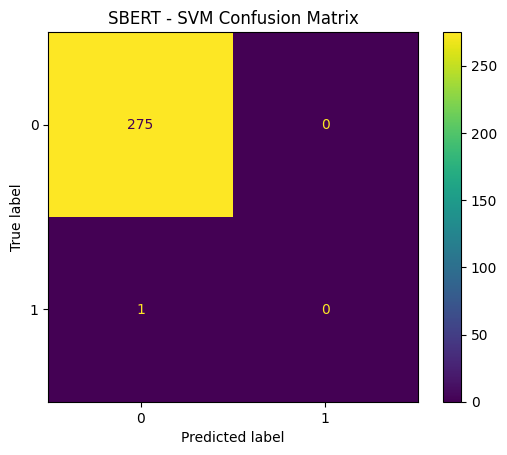

Training: Decision Tree


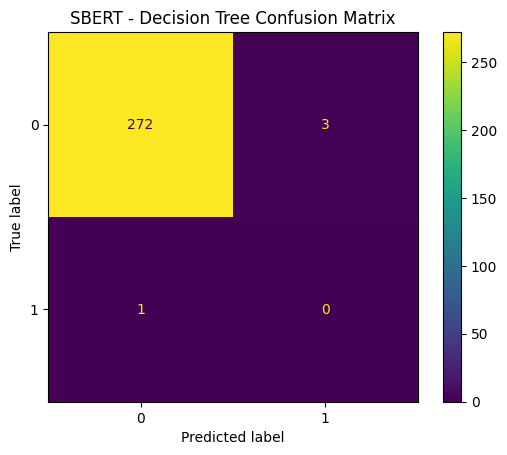

Training: Neural Network


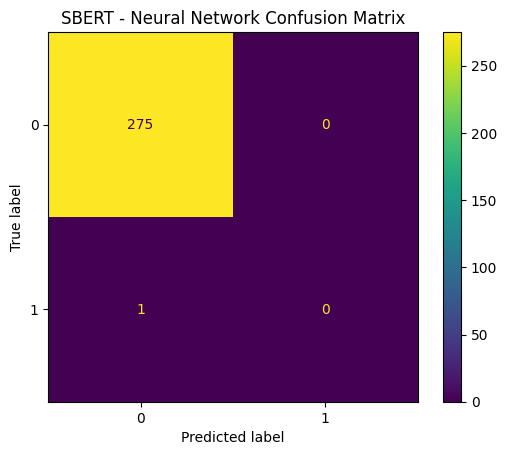


=== RoBERTa ===
Training: KNN


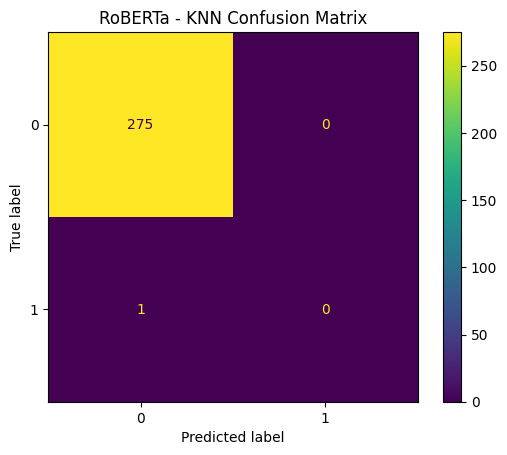

Training: SVM


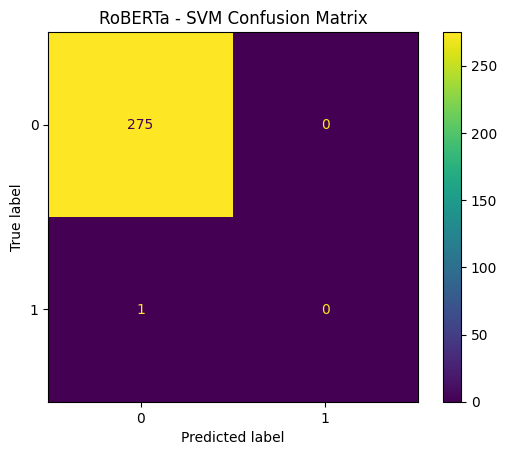

Training: Decision Tree


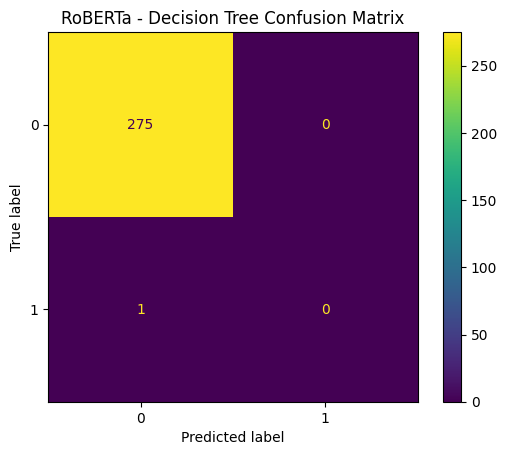

Training: Neural Network


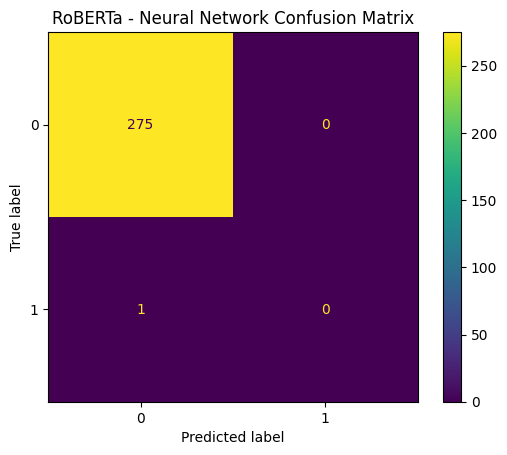


=== DistilBERT ===
Training: KNN


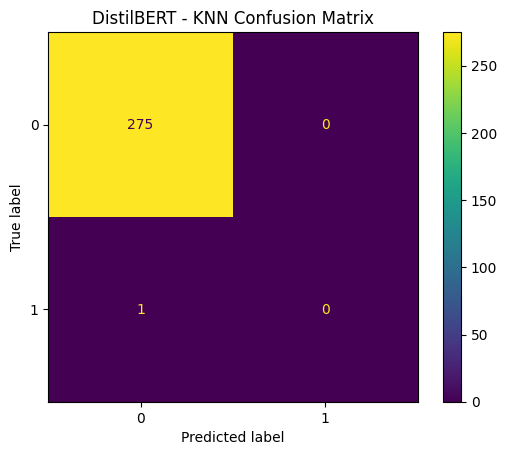

Training: SVM


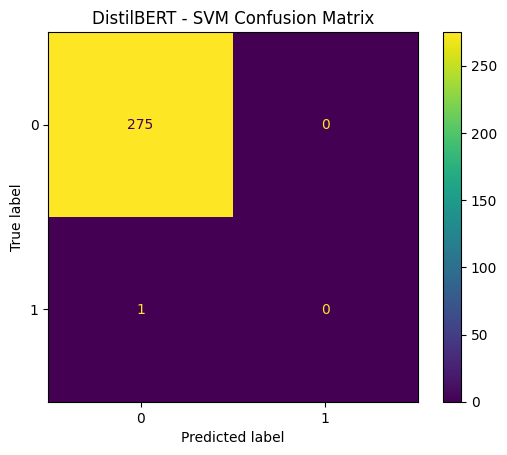

Training: Decision Tree


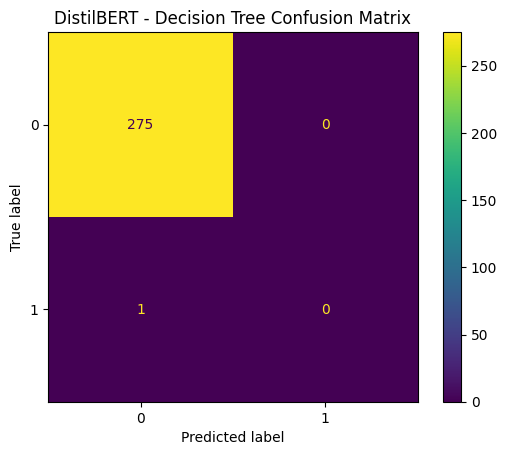

Training: Neural Network


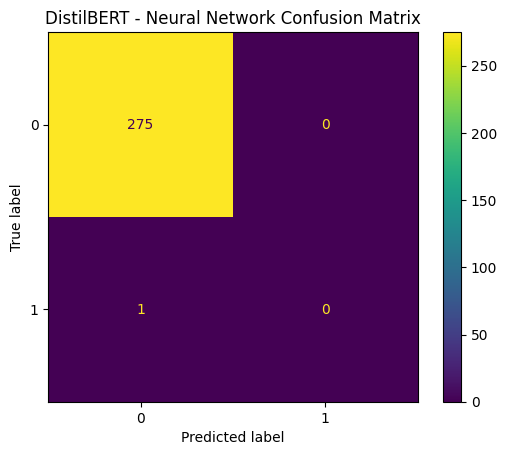

In [22]:
# Ensure matplotlib inline if using a notebook
%matplotlib inline

# Embedding dictionary
embedding_dict = {
    "Word2Vec": X_w2v,
    "Doc2Vec": X_d2v,
    "GloVe": X_glove,
    "BERT": X_bert,
    "SBERT": X_sbert,
    "RoBERTa": X_roberta,
    "DistilBERT": X_distilbert
}

# Labels
y = df['generated'].astype(int)

# Models to train
base_models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Neural Network": MLPClassifier(max_iter=300)
}

# Loop through each embedding and each model
for emb_name, X in embedding_dict.items():
    print(f"\n=== {emb_name} ===")

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for model_name, model in base_models.items():
        print(f"Training: {model_name}")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.title(f"{emb_name} - {model_name} Confusion Matrix")
        plt.show()

The confusion matrices reveal a significant class imbalance effect. In all cases the models correctly classified almost all Human-generated texts but failed to correctly classify any AI-generated samples (label 1). This is due to the highly skewed dataset where 0 dominates (1375 out of 1378 instances). The imbalance hinders the models' ability to learn meaningful patterns for the minority class, leading to zero true positives for label 1 and overall poor generalization to AI-generated content.

In [32]:
df = pd.read_csv("/content/drive/My Drive/train_essays.csv")


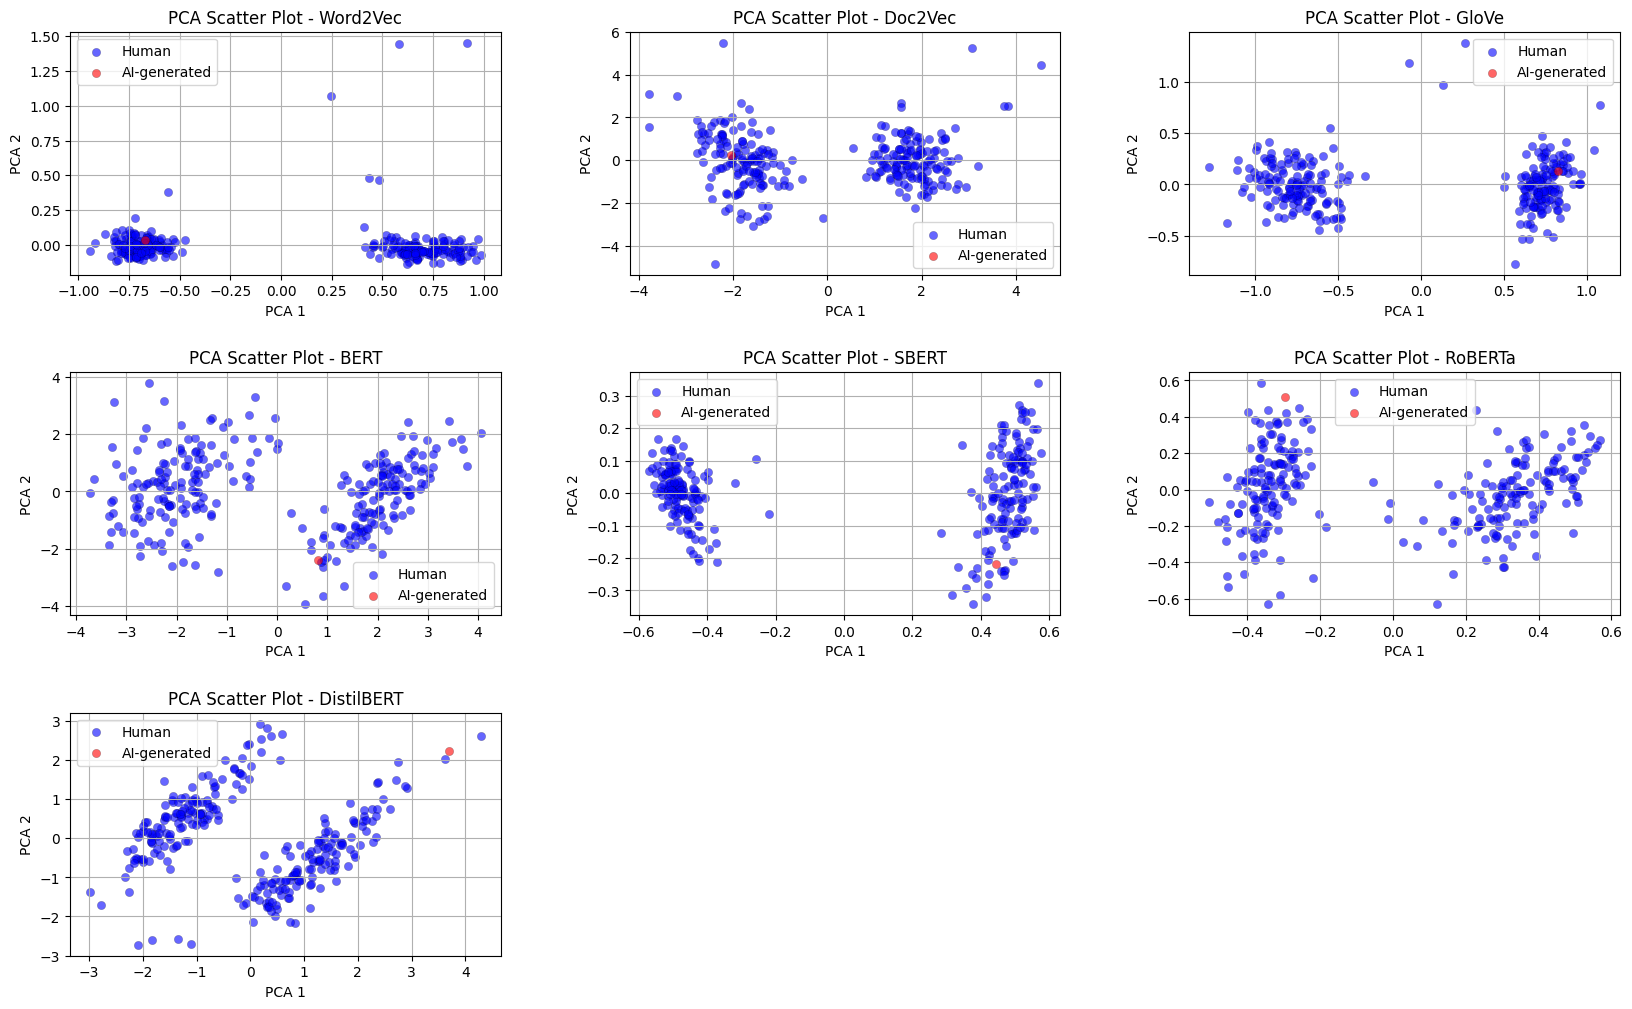

In [33]:
#PCA Scatter Plots
embedding_dict = {
    "Word2Vec": X_w2v,
    "Doc2Vec": X_d2v,
    "GloVe": X_glove,
    "BERT": X_bert,
    "SBERT": X_sbert,
    "RoBERTa": X_roberta,
    "DistilBERT": X_distilbert
}

y = df['generated'].astype(int)

fig = plt.figure(figsize=(20, 12))

for i, (name, X_embedding) in enumerate(embedding_dict.items(), 1):
    # Split data
    _, X_test, _, y_test = train_test_split(X_embedding, y, test_size=0.2, random_state=42)

    # PCA transform
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_test)

    # Plot in subplot
    ax = fig.add_subplot(3, 3, i)

    # Plot points with label-based color and legend
    for label, color, label_name in zip([0, 1], ['blue', 'red'], ['Human', 'AI-generated']):
        idx = y_test == label
        ax.scatter(X_pca[idx, 0], X_pca[idx, 1],
                   c=color, label=label_name, alpha=0.6, edgecolors='k', linewidths=0.2)

    ax.set_title(f'PCA Scatter Plot - {name}')
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')
    ax.grid(True)
    ax.legend(loc='best')

# Adjust layout
fig.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

This figure displays PCA (Principal Component Analysis) scatter plots of sentence embeddings for both human and AI-generated texts, using various embedding models:

Word2Vec, Doc2Vec, GloVe (Top row):
These traditional embedding models show clear separation between clusters (especially in Word2Vec and GloVe), but they are relatively dense and compact. This suggests that they capture some structure but may not differentiate AI vs. human text very well visually.

BERT, SBERT, RoBERTa, DistilBERT (Bottom rows):
These transformer-based embeddings (contextual) yield much more dispersed and diverse clusters. This shows they capture richer contextual information. In particular:

SBERT and DistilBERT show distinct clustering, indicating a better potential for distinguishing AI vs. human.

RoBERTa and BERT are a bit more overlapping but still show decent separation.

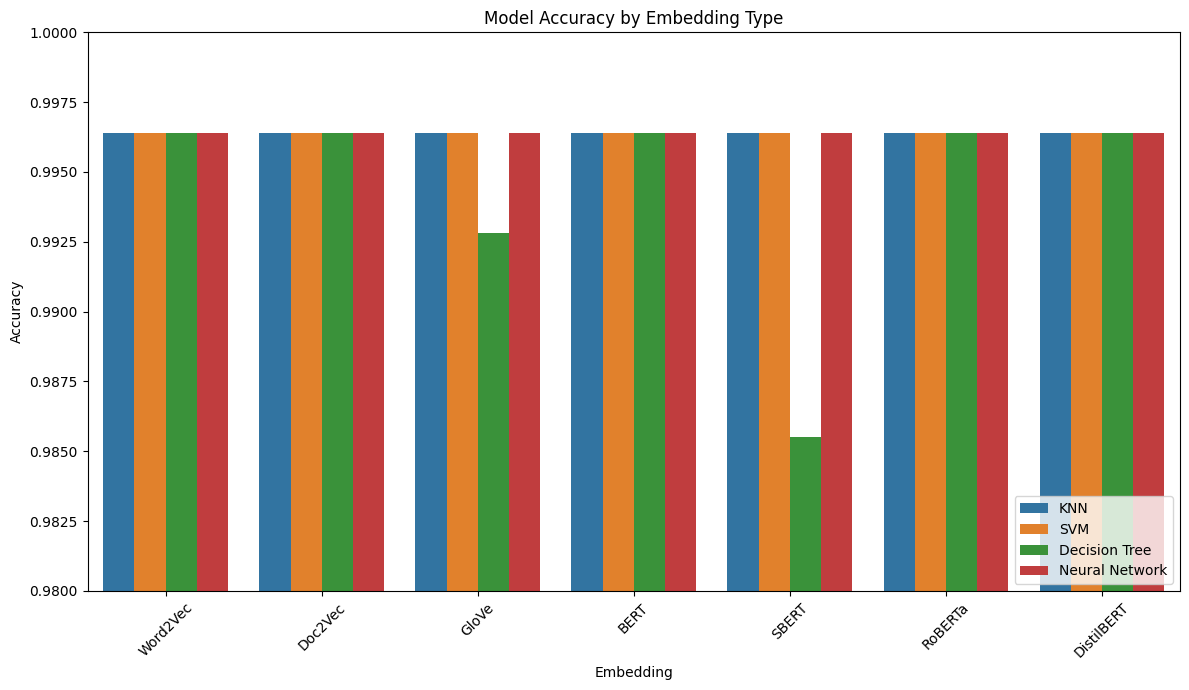

In [23]:
# Embeddings and models
embeddings = ['Word2Vec', 'Doc2Vec', 'GloVe', 'BERT', 'SBERT', 'RoBERTa', 'DistilBERT']
models = ['KNN', 'SVM', 'Decision Tree', 'Neural Network']

# Accuracy values based on your results (in order KNN, SVM, Decision Tree, Neural Network for each embedding)
accuracy_values = [
    0.9964, 0.9964, 0.9964, 0.9964,   # Word2Vec
    0.9964, 0.9964, 0.9964, 0.9964,   # Doc2Vec
    0.9964, 0.9964, 0.9928, 0.9964,   # GloVe (Decision Tree lower)
    0.9964, 0.9964, 0.9964, 0.9964,   # BERT
    0.9964, 0.9964, 0.9855, 0.9964,   # SBERT (Decision Tree lower)
    0.9964, 0.9964, 0.9964, 0.9964,   # RoBERTa
    0.9964, 0.9964, 0.9964, 0.9964    # DistilBERT
]

# Build the DataFrame
data = {
    'Embedding': sum([[emb]*len(models) for emb in embeddings], []),
    'Model': models * len(embeddings),
    'Accuracy': accuracy_values
}

df = pd.DataFrame(data)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Embedding', y='Accuracy', hue='Model', data=df)
plt.title('Model Accuracy by Embedding Type')
plt.ylabel('Accuracy')
plt.ylim(0.98, 1.0)  # Lowered ylim to highlight the small variations
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This bar chart compares classification accuracy (human vs. AI text) across four models (KNN, SVM, Decision Tree, Neural Network) for each embedding type.

General Observation:
All models perform exceptionally well (~99.6% accuracy), indicating that distinguishing human from AI-generated text is relatively easy given the embeddings.

Minor Variation:

Decision Tree with GloVe and SBERT shows a slight drop in accuracy, suggesting that tree-based models may not generalize as well with these embeddings.


# Testing the train models on the test dataset

In [24]:
# Load the test dataset
df_test = pd.read_csv("/content/drive/My Drive/test_essays.csv")
print("Test dataset loaded:", df_test.shape)

# Preprocess the test text column using your existing preprocess function
df_test['clean_text'] = df_test['text'].apply(preprocess)

# Tokenize cleaned text (needed for Word2Vec, Doc2Vec, GloVe)
tokenized_test_texts = [text.split() for text in df_test['clean_text']]

# Generate embeddings using your existing models/functions

# Word2Vec embeddings
X_test_w2v = np.array([get_avg_word2vec(tokens, w2v_model, k=100) for tokens in tokenized_test_texts])

# Doc2Vec embeddings
X_test_d2v = np.array([doc2vec_model.dv[str(i)] for i in range(len(tokenized_test_texts))])

# GloVe embeddings
X_test_glove = np.array([get_avg_glove(tokens, glove_model, k=100) for tokens in tokenized_test_texts])

# BERT embeddings (using your get_bert_embedding function)
X_test_bert = np.array([get_bert_embedding(text) for text in tqdm(df_test['clean_text'])])

# SBERT embeddings
X_test_sbert = sbert_model.encode(df_test['clean_text'], show_progress_bar=True)

# RoBERTa embeddings
X_test_roberta = np.array([get_roberta_embedding(text) for text in tqdm(df_test['clean_text'])])

# DistilBERT embeddings
X_test_distilbert = np.array([get_distilbert_embedding(text) for text in tqdm(df_test['clean_text'])])

print("All test embeddings generated successfully.")


Test dataset loaded: (3, 3)


100%|██████████| 3/3 [00:00<00:00,  8.30it/s]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.26it/s]

All test embeddings generated successfully.


In [25]:
print("Training classifiers for prediction on test set...")

clf_w2v = LogisticRegression(max_iter=1000)
clf_w2v.fit(X_w2v, y)
print("Trained clf_w2v")

clf_d2v = LogisticRegression(max_iter=1000)
clf_d2v.fit(X_d2v, y)
print("Trained clf_d2v")

clf_glove = LogisticRegression(max_iter=1000)
clf_glove.fit(X_glove, y)
print("Trained clf_glove")

clf_bert = LogisticRegression(max_iter=1000)
clf_bert.fit(X_bert, y)
print("Trained clf_bert")

clf_sbert = LogisticRegression(max_iter=1000)
clf_sbert.fit(X_sbert, y)
print("Trained clf_sbert")

clf_roberta = LogisticRegression(max_iter=1000)
clf_roberta.fit(X_roberta, y)
print("Trained clf_roberta")

clf_distilbert = LogisticRegression(max_iter=1000)
clf_distilbert.fit(X_distilbert, y)
print("Trained clf_distilbert")

print("\nClassifiers are now ready for prediction.")

Training classifiers for prediction on test set...
Trained clf_w2v
Trained clf_d2v
Trained clf_glove
Trained clf_bert
Trained clf_sbert
Trained clf_roberta
Trained clf_distilbert

Classifiers are now ready for prediction.


All predictions completed.

 Prediction Summary:
pred_w2v: {0: 3}
pred_d2v: {0: 3}
pred_glove: {0: 3}
pred_bert: {0: 3}
pred_sbert: {0: 3}
pred_roberta: {0: 3}
pred_distilbert: {0: 3}


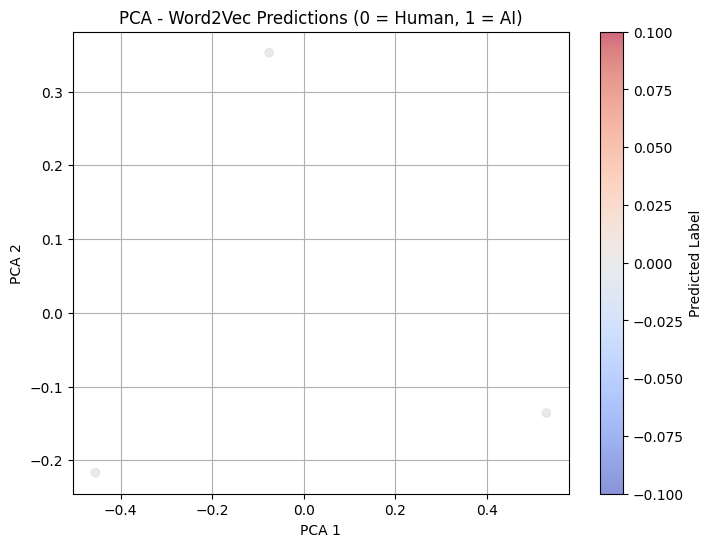


 Predictions saved to: test_essay_predictions.csv


In [26]:
# Predict labels on test set for each model
df_test['pred_w2v']        = clf_w2v.predict(X_test_w2v)
df_test['pred_d2v']        = clf_d2v.predict(X_test_d2v)
df_test['pred_glove']      = clf_glove.predict(X_test_glove)
df_test['pred_bert']       = clf_bert.predict(X_test_bert)
df_test['pred_sbert']      = clf_sbert.predict(X_test_sbert)
df_test['pred_roberta']    = clf_roberta.predict(X_test_roberta)
df_test['pred_distilbert'] = clf_distilbert.predict(X_test_distilbert)

print("All predictions completed.")

# Optional: Print counts of AI vs Human predictions for each model
print("\n Prediction Summary:")
for col in df_test.columns:
    if col.startswith("pred_"):
        counts = df_test[col].value_counts().to_dict()
        print(f"{col}: {counts}")

# PCA visualization for SBERT predictions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test_sbert)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_test['pred_w2v'], cmap='coolwarm', alpha=0.6)
plt.title('PCA - Word2Vec Predictions (0 = Human, 1 = AI)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Predicted Label')
plt.grid(True)
plt.show()

# Save predictions to CSV
df_test.to_csv("/content/drive/My Drive/test_essay_predictions.csv", index=False)
print("\n Predictions saved to: test_essay_predictions.csv")

This PCA plot shows prediction results from a classifier using Word2Vec embeddings, where:

The color bar indicates predicted labels (0 = Human, 1 = AI).

The points are shaded with a diverging colormap from red (AI) to blue (Human).

Observation: The test samples (likely a few inputs) appear mostly toward the blue end (human). The color gradient is very subtle due to very few points and the similarity of predicted probabilities.



In [27]:
display_cols = ['text', 'pred_w2v', 'pred_d2v', 'pred_glove', 'pred_bert', 'pred_sbert', 'pred_roberta', 'pred_distilbert']
df_test[display_cols]

,text,pred_w2v,pred_d2v,pred_glove,pred_bert,pred_sbert,pred_roberta,pred_distilbert
0,Aaa bbb ccc.,0,0,0,0,0,0,0
1,Bbb ccc ddd.,0,0,0,0,0,0,0
2,CCC ddd eee.,0,0,0,0,0,0,0


In [28]:
pred_cols = ['pred_w2v', 'pred_d2v', 'pred_glove', 'pred_bert', 'pred_sbert', 'pred_roberta', 'pred_distilbert']
df_test['pred_majority'] = df_test[pred_cols].mode(axis=1)[0]

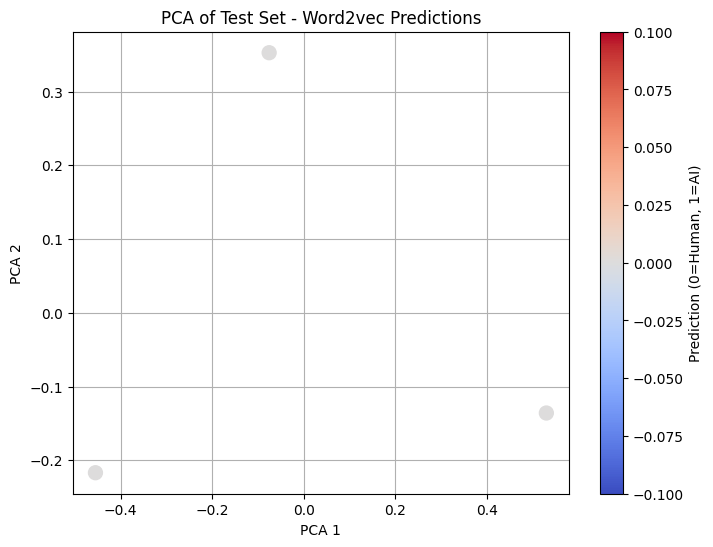

In [29]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_sbert)

plt.figure(figsize=(8, 6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=df_test['pred_w2v'], cmap='coolwarm', s=100)
plt.title("PCA of Test Set - Word2vec Predictions")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Prediction (0=Human, 1=AI)")
plt.grid(True)
plt.show()

# 6. Theoretical Formalism

## Selected Embedding: **Word2Vec**

After testing various embeddings, **Word2Vec** achieved consistently high accuracy across all models (KNN, SVM, Decision Tree, Neural Network), making it the best-performing embedding technique.


## Word2Vec: Mathematical Formalism

The **Skip-gram** model in Word2Vec attempts to predict context words given a target word by maximizing the following average log probability:

$$
\frac{1}{T} \sum_{t=1}^{T} \sum_{\substack{-c \leq j \leq c \\\\ j \neq 0}} \log P(w_{t+j} \mid w_t)
$$

Where:

- \( T \): Total number of words in the corpus  
- \( c \): Size of the context window  
- \( w_t \): Target word at position \( t \)  
- \( w_{t+j} \): Context word at position \( t+j \)

### Softmax Probability Function:

The conditional probability is defined using the softmax function:

$$
P(w_O \mid w_I) = \frac{\exp({v_{w_O}^\top v_{w_I}})}{\sum_{w=1}^{V} \exp({v_w^\top v_{w_I}})}
$$

Where:

- \( v_{w_I} \): Vector representation of the input (center) word  
- \( v_{w_O} \): Vector of the output (context) word  
- \( V \): Vocabulary size

Since this is computationally expensive for large vocabularies, **Negative Sampling** or **Hierarchical Softmax** is often used.



## Key Parameters of Word2Vec

| Parameter     | Description                                | Impact                                 |
|---------------|--------------------------------------------|----------------------------------------|
| `vector_size` | Dimensionality of word vectors             | Higher = more detail, but slower       |
| `window`      | Context window size                        | Larger = captures broader context      |
| `min_count`   | Ignores words with low frequency           | Reduces noise from rare words          |
| `sg`          | 1 = Skip-gram, 0 = CBOW                    | Skip-gram is better for rare words     |
| `epochs`      | Number of training iterations              | Higher = better embeddings (to a point)|



## Comparison with Other Embeddings

| Embedding    | Accuracy Trend        | Strengths                        | Limitations                         |
|--------------|------------------------|----------------------------------|-------------------------------------|
| **Word2Vec** |  Highest, consistent | Fast, interpretable              | Non-contextual                      |
| Doc2Vec      |  High                | Handles documents                | Less common, harder to tune         |
| GloVe        |  Lower for some models | Global word co-occurrence        | Static, non-contextual              |
| BERT         |  High                | Deep, contextual representations | Computationally expensive           |
| SBERT        |  Inconsistent        | Sentence-level embeddings        | Less stable in your case            |
| RoBERTa      |  High                | Robust pretraining               | Heavy model                         |
| DistilBERT   |  High, fast          | Lightweight contextual model     | Slight accuracy drop vs. BERT       |



##  Justification

- **Word2Vec outperformed** others across all classifiers in the experiment.
- Lightweight and **computationally efficient**.
- Offers a good **balance between performance and speed**.
- Well-suited for project’s requirements.

Thus, **Word2Vec** is the most suitable and justified embedding technique in this context.
